In [132]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [133]:
train_data = torchvision.datasets.MNIST(
    root="data",
    download=True,
    train=True,
    transform=torchvision.transforms.ToTensor(),
)



In [134]:
test_data = torchvision.datasets.MNIST(
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor(),
)

In [135]:
len(train_data.data),len(test_data.data)

(60000, 10000)

In [136]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

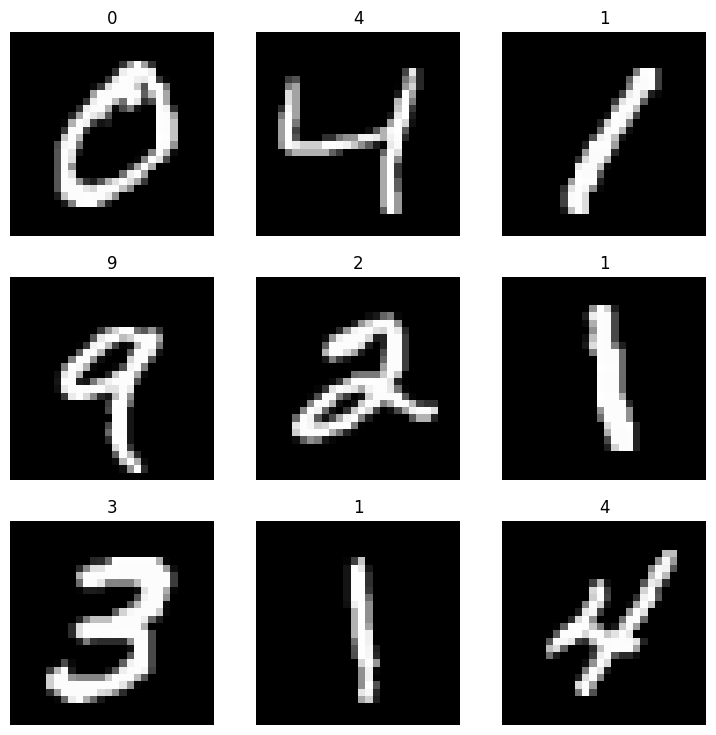

In [137]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i in range(1,nrows * nrows+1):
    plt.subplot(nrows,ncols,i)
    plt.title(train_data.targets[i].item())
    plt.imshow(train_data.data[i],cmap="gray")
    plt.axis(False)

In [138]:
import torch.utils
torch.manual_seed(42)

train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [139]:
len(train_dataloader),len(test_dataloader)

(1875, 313)

In [140]:
from torch import nn
class Conv2DModel(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
               kernel_size=2
            ),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [141]:
model = Conv2DModel(input_shape=1,hidden_units=16,output_shape=len(class_names))
model

Conv2DModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [142]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)
accuracy_fn = Accuracy(task="multiclass",num_classes=len(class_names))

In [143]:
def train_step(model:nn.Module,loss_fn,accuracy_fn,device):
    model.train(),
    train_loss = 0
    for batch,( X,y )in enumerate(train_dataloader):
        X ,y = X.to(device),y.to(device)
        y_logits = model(X)
        y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
        
        loss = loss_fn(y_logits,y)
        train_loss += loss
        acc = accuracy_fn(y_preds.cpu(),y.cpu())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    
    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {acc:.4f}")

In [144]:
def test_step(model:nn.Module,loss_fn,accuracy_fn,device):
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X,y in test_dataloader:
            X ,y = X.to(device),y.to(device)
            y_logits = model(X)
            y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

            loss = loss_fn(y_logits,y)
            test_loss += loss
            acc = accuracy_fn(y_preds.cpu(),y.cpu())
        test_loss /= len(test_dataloader)
        print(f"Test loss: {test_loss:.4f} | Test acc: {acc:.4f}")

In [145]:
def print_train_time(start:float,end:float,device=torch.device):
    
    total_time = end - start
    print(f"Waktu yang dibutuhkan untuk train {total_time} di device {device}")
    
    return total_time

In [146]:
def eval_model(model:nn.Module,loss_fn,accuracy_fn,device):
    model.eval()
    test_loss = 0
    epochs = 3
    for epochs in tqdm(range(epochs)):
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                y_logits = model(X)
                y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

                loss = loss_fn(y_logits, y)
                test_loss += loss
                acc = accuracy_fn(y_preds.cpu(), y.cpu())
            test_loss /= len(test_dataloader)
    return {"model_name": model.__class__.__name__, "model_loss": test_loss , "mode_acc": acc}

In [147]:
# epochs = 3

# for epoch in range(epochs):
#     print(f"Epoch: {epoch}")
#     train_step(model,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device="cpu")
#     test_step(model,loss_fn,accuracy_fn,device="cpu")

In [148]:
# model_results = eval_model(model=model,accuracy_fn=accuracy_fn,device="cpu",loss_fn=loss_fn)
# model_results

In [149]:
epochs = 3
model.to("cuda")
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    train_step(model, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device="cuda")
    test_step(model, loss_fn, accuracy_fn, device="cuda")

Epoch: 0
Train loss: 0.2506 | Train acc: 0.9375
Test loss: 0.0879 | Test acc: 1.0000
Epoch: 1
Train loss: 0.0613 | Train acc: 0.9375
Test loss: 0.0680 | Test acc: 1.0000
Epoch: 2
Train loss: 0.0466 | Train acc: 0.9688
Test loss: 0.0443 | Test acc: 1.0000


In [165]:
model.to("cuda")

y_preds = []
model.eval()
with torch.inference_mode():
    for X,y in test_dataloader:
        X,y = X.to("cuda"),y.to("cuda")
        y_logits = model(X)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred)
        

y_preds_tensor = torch.cat(y_preds)
y_preds_tensor[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

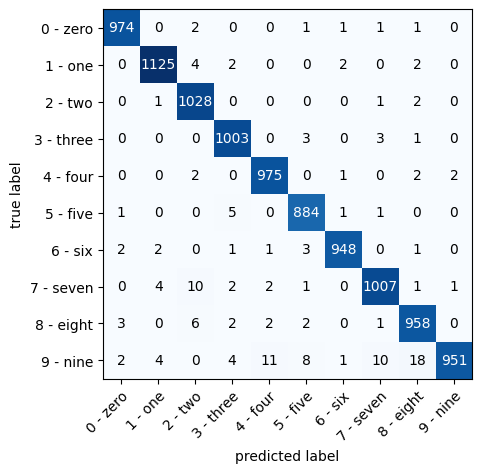

In [176]:
from mlxtend import plotting
import torchmetrics

conf_matrix = torchmetrics.ConfusionMatrix(task="multiclass",num_classes=len(class_names))
conf_matrix_tensor = conf_matrix(preds= y_preds_tensor.cpu(),target=test_data.targets)

plotting.plot_confusion_matrix(conf_mat=conf_matrix_tensor.numpy(),class_names=class_names)